In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from matplotlib import rc
rc('font', family='AppleGothic')

In [32]:
df = pd.read_csv('rfm_data2.csv', parse_dates=['InvoiceDate'])
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392692 entries, 0 to 392691
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392692 non-null  int64         
 1   StockCode    392692 non-null  object        
 2   Description  392692 non-null  object        
 3   Quantity     392692 non-null  int64         
 4   InvoiceDate  392692 non-null  datetime64[ns]
 5   UnitPrice    392692 non-null  float64       
 6   CustomerID   392692 non-null  int64         
 7   Country      392692 non-null  object        
 8   TotalPrice   392692 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(3)
memory usage: 27.0+ MB


# RFM Segmentation

- RFM score을 1 - 3점으로 분류
- Recency : 고객이 얼마나 최근에 구매를 하였는지
- Frequency : 고객이 얼마나 자주 구매를 하였는지
- Monetary : 고객이 총 얼마를 구매하였는지


## 고객 분류
- 아래의 분류를 따르기로 결정
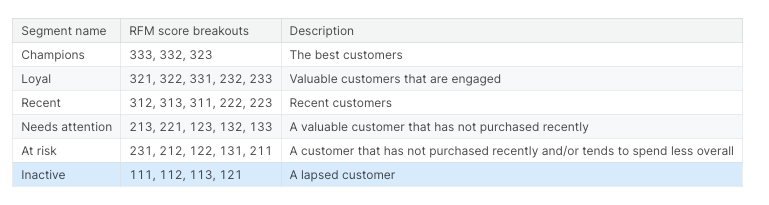

In [21]:
# 가장 최근 거래일 파악
df['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

In [3]:
# 현재 날짜를 가장 최근 거래가 만들어진 이후 2일 후에 분석이 이루어졌다고 가정하고 세팅
current_date = dt.datetime(2011,12,11)

In [43]:
# rfm 데이터 생성
rfm = df.groupby('CustomerID').agg({'InvoiceDate' : lambda InvoiceDate : (current_date - InvoiceDate.max()).days,
                                   'InvoiceNo' : lambda InvoiceNo : InvoiceNo.nunique(),
                                   'TotalPrice' : lambda TotalPrice : TotalPrice.sum()})
rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346,326,1,77183.60
12347,3,7,4310.00
12348,76,4,1797.24
12349,19,1,1757.55
12350,311,1,334.40


In [5]:
rfm.describe().round(2)

,Recency,Frequency,Monetary
count,4338.00,4338.00,4338.00
mean,93.06,4.27,2048.69
std,100.01,7.70,8985.23
min,1.00,1.00,3.75
25%,18.00,1.00,306.48
50%,51.00,2.00,668.57
75%,142.75,5.00,1660.60
max,374.00,209.00,280206.02


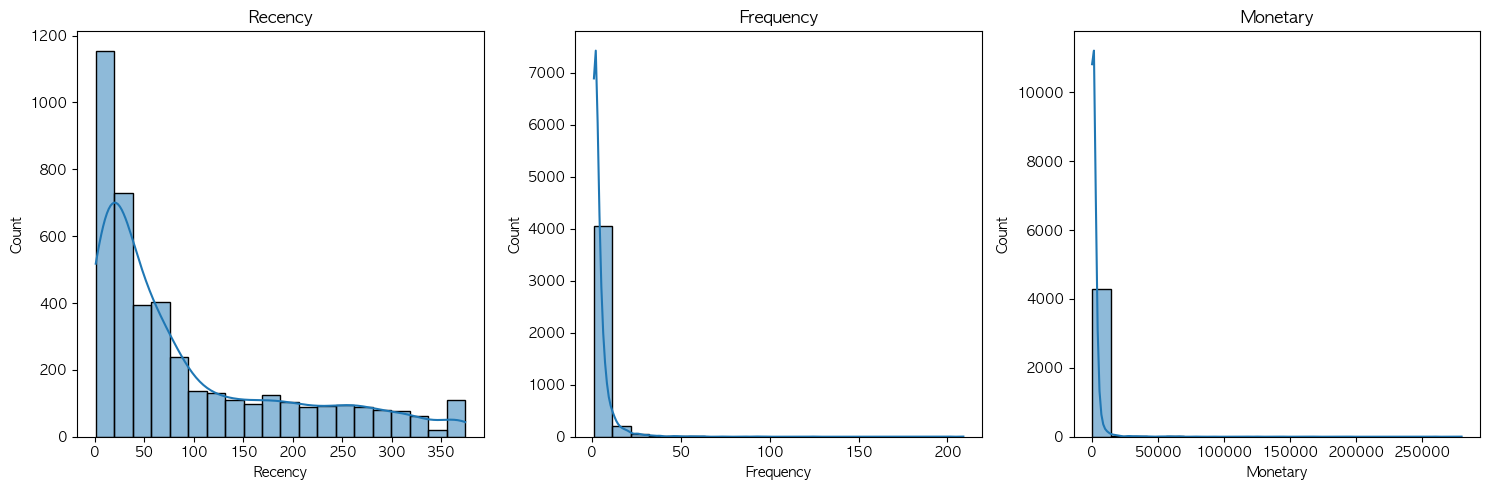

In [23]:
# 컬럼 별 분포 확인
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

sns.histplot(rfm['Recency'], bins=20, ax=axes[0], kde=True)
sns.histplot(rfm['Frequency'], bins=20, ax=axes[1], kde=True)
sns.histplot(rfm['Monetary'], bins=20, ax=axes[2], kde=True)

axes[0].set_title('Recency')
axes[1].set_title('Frequency')
axes[2].set_title('Monetary')

plt.tight_layout()
plt.show()

In [44]:
# RFM Score
rfm['R_Score'] = pd.qcut(rfm['Recency'], 3, labels=[3, 2, 1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 3, labels=[1, 2, 3])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 3, labels=[1, 2, 3])
rfm['RFM_Score'] = rfm['R_Score'].astype('str') + rfm['F_Score'].astype('str') + rfm['M_Score'].astype('str')
rfm.head()

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
CustomerID,,,,,,,
12346,326,1,77183.60,1,1,3,113
12347,3,7,4310.00,3,3,3,333
12348,76,4,1797.24,2,2,3,223
12349,19,1,1757.55,3,1,3,313
12350,311,1,334.40,1,1,1,111


In [45]:
# Segmentation depending on RFM Score
# RFM 점수에 따른 세그멘테이션
def seg_customers(rfm_score) :
    if rfm_score in ['111', '112', '113', '121']:
        return 'Inactive'
    elif rfm_score in ['231', '212', '122', '131', '211']:
        return 'At risk'
    elif rfm_score in ['213', '221', '123', '132', '133']:
        return 'Needs Attention'
    elif rfm_score in ['312', '313', '311', '222', '223']:
        return 'Recent'
    elif rfm_score in ['321', '322', '331', '232', '233']:
        return 'Loyal'
    elif rfm_score in ['333', '332', '323']:
        return 'Champions'
    
rfm['Segment'] = rfm['RFM_Score'].apply(seg_customers)
rfm.head()

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment
CustomerID,,,,,,,,
12346,326,1,77183.60,1,1,3,113,Inactive
12347,3,7,4310.00,3,3,3,333,Champions
12348,76,4,1797.24,2,2,3,223,Recent
12349,19,1,1757.55,3,1,3,313,Recent
12350,311,1,334.40,1,1,1,111,Inactive


In [46]:
rfm.to_csv('seg_data1.csv')

In [49]:
rfm.reset_index(inplace=True)
rfm = rfm.groupby('Segment').agg({'CustomerID' : 'count'})

In [50]:
rfm.head()

,CustomerID
Segment,
At risk,703
Champions,960
Inactive,974
Loyal,778
Needs Attention,334


In [51]:
rfm.to_csv('seg_data2.csv')